<center>
<h1>CSC-343 ARTIFICIAL INTELLIGENCE</h1>
<h1>PROGRAMMING ASSIGNMENT 10</h1>
<h1>BACK PROPAGATION</h1>
</center>

<br/>
<hr/>
<br/>

## Imports

In [1]:
import pandas as pd
import numpy  as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

## Reading Data

In [2]:
data  = pd.read_csv('https://raw.githubusercontent.com/fahadsultan/csc343/main/data/uscities.csv', index_col='city')

In [3]:
# river = pd.read_csv('https://raw.githubusercontent.com/fahadsultan/csc343/main/data/savannah.csv', index_col = 0)
# river = river[280:-70]

data  = data[data['state_name'].apply(lambda x: x in ['Georgia', 'South Carolina', 'North Carolina'])]
data  = data[~data.index.duplicated(keep='last')]

X     = data[['lng', 'lat']]
y     = (data['state_name'] == 'South Carolina').astype(int)

## Plotting Data

In [4]:
def plot_data(X, y, title):

  fig = plt.figure(figsize=(50, 20))

  ga, sc = X[y==0], X[y==1]

  for X_state, color in [(ga, "red"), (sc, "blue")]:

    plt.scatter(X_state['lng'], X_state['lat'], c=color, s=70, figure=fig)

    [plt.annotate(X_state.index[i],\
        (X_state.iloc[i]['lng'], X_state.iloc[i]['lat']), \
        fontsize=10) \
      for i in range(len(X_state.index))]

  plt.title(title, fontsize=30);
  plt.grid()

In [5]:
# plot_data(X, y, title='Click to zoom')

# # plt.plot(river['0'], river['1'], linewidth=20, color='lightblue')

# plt.legend(['Georgia and North Carolina (y=0)', 'South Carolina (y=1)'], fontsize=50, markerscale=4);

# Normalize data

In [6]:
X = X.apply(lambda x: (x-x.mean()) / x.std())
# X[0] = 1  #Done in the methods of Neural Network now

<br/>
<hr/>
<br/>

## Question 1.

Write a function that takes <u>**randomly**</u>  **splits** the data into **75% training** set and **25% test** set.


In [7]:
train_cities = list(set(X.sample(frac=0.75).index))
test_cities  = list(set(X.index).difference(train_cities))

X_train, y_train = X.loc[train_cities], y.loc[train_cities]
X_test,  y_test  = X.loc[test_cities],  y.loc[test_cities]

# plot_data(X_train, y_train, "Training set");
# plt.figure();
# plot_data(X_test, y_test, "Test set");

<br/>
<hr/>
<br/>

In [8]:
y.value_counts()

state_name
0    1239
1     394
Name: count, dtype: int64

In [9]:
train_cities = list(set(X.sample(frac=0.60).index))
test_cities  = list(set(X.index).difference(train_cities))

X_train, y_train = X.loc[train_cities], y.loc[train_cities]
X_test,  y_test  = X.loc[test_cities],  y.loc[test_cities]

import tensorflow as tf
model = tf.keras.Sequential([
    # tf.keras.layers.Flatten(input_shape=(2,1)),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    tf.keras.layers.Dense(20, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=150)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predictions = probability_model.predict(X_test)

Epoch 1/150
31/31 [==============================] - 2s 4ms/step - loss: 0.5882 - accuracy: 0.7500
Epoch 2/150
31/31 [==============================] - 0s 3ms/step - loss: 0.5619 - accuracy: 0.7500
Epoch 3/150
31/31 [==============================] - 0s 3ms/step - loss: 0.5622 - accuracy: 0.7500
Epoch 4/150
31/31 [==============================] - 0s 6ms/step - loss: 0.5621 - accuracy: 0.7500
Epoch 5/150
31/31 [==============================] - 0s 6ms/step - loss: 0.5618 - accuracy: 0.7500
Epoch 6/150
31/31 [==============================] - 0s 8ms/step - loss: 0.5621 - accuracy: 0.7500
Epoch 7/150
31/31 [==============================] - 0s 7ms/step - loss: 0.5620 - accuracy: 0.7500
Epoch 8/150
31/31 [==============================] - 0s 8ms/step - loss: 0.5622 - accuracy: 0.7500
Epoch 9/150
31/31 [==============================] - 0s 10ms/step - loss: 0.5614 - accuracy: 0.7500
Epoch 10/150
31/31 [==============================] - 0s 7ms/step - loss: 0.5615 - accuracy: 0.7500
Epoch 11

In [10]:
import networkx as nx


# Assuming you have Ws defined earlier, and Ws[-1] contains W1 and W2
# Define the weight matrices (taken from Ws[-1])
weights = model.weights
# Create a directed graph
G = nx.DiGraph()

pos = {}
# Add nodes for first column
col = 0
print(len(weights))
i = 0
z = 0
maxRows = 0
for z in range(len(weights)):
  maxRows = max(maxRows, weights[z].shape[0])
  z += 2

maxRows += 1

while i < len(weights): #gets weights associated with the a column
  w = weights[i]

  for sourceRow in range(w.shape[0]): # gets weights associated with a node
    source_node = 'l_' + str(sourceRow) + '_' + str(col)
    pos[source_node] = (col, maxRows//(w.shape[0] + 1) * (sourceRow + 1) * -5)

    for row in range(w.shape[1]):
      dest_node = 'l_' + str(row) + '_' + str(col+1)
      G.add_edge(source_node, dest_node, weight = w[sourceRow][row])
      pos[dest_node] = (col + 1, maxRows//(w.shape[1] + 1) * (row + 1) * -5)

  i += 2
  col += 1

6


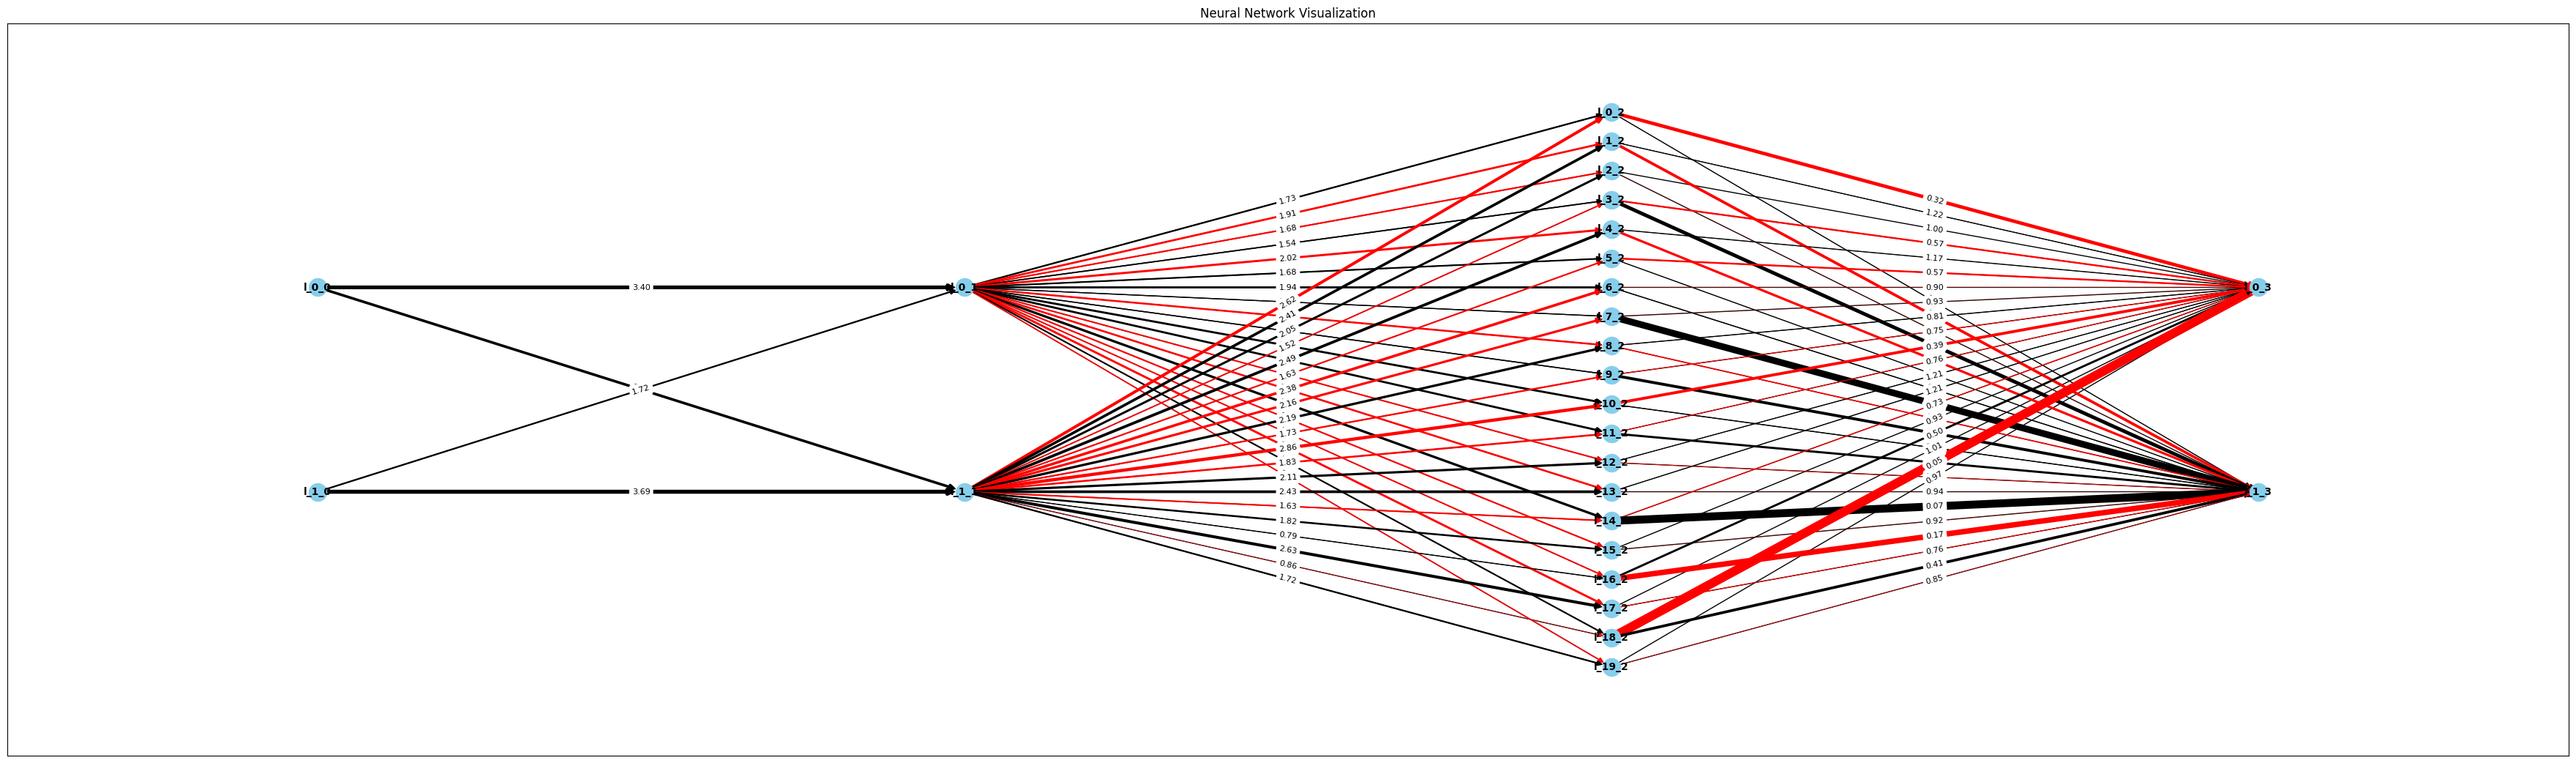

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import math

edge_colors = []
alpha = []
width = []
for u, v, d in G.edges(data=True):
    # print("Source is", u, "destination is", v, "and weight is", d["weight"])
    if d['weight'] > 0:
        edge_colors.append('black')
        value = (d['weight'] **(3/2))
    else:
        d['weight'] *= -1
        edge_colors.append('red')
        value = (d['weight'] **(3/2))
        # print("stuff happened")
    alpha.append( d['weight'])

    cubed_value = d['weight'] ** 3
    if cubed_value > 0:
        log_of_cubed_value = math.log(cubed_value)  # natural logarithm (base e)
    else:
        cubed_value *= -1
        log_of_cubed_value = math.log(cubed_value)
    width.append(log_of_cubed_value)

plt.figure(figsize=(35, 10))

nx.draw(G, pos=pos, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)

nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, arrows=True, width = width)


edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=8)

plt.title('Neural Network Visualization')

plt.axis('on')
plt.margins(0.1)

plt.show()

# Beautiful Sankey Diagram

In [12]:
import plotly.graph_objects as go
import networkx as nx
import random

source = []
target = []
weights_list = []
edges = G.edges(data=True)
edges = sorted(edges)
# print("Length of edges:", len(edges))
for u, v, d in edges:
  # if d["weight"] < 0:
  #   print("Negative")
  # print("Source is", u, "destination is", v, "and weight is", d["weight"])
  # cubed_value = d['weight'] ** 3
  # if cubed_value > 0:
  #     cubed_value = math.log(cubed_value, 10)  # natural logarithm (base e)
  # else:
  #     cubed_value *= -1
  source.append(u)
  target.append(v)
  weights_list.append(d["weight"].numpy() ** 3)

node_to_index = {node: i for i, node in enumerate(sorted(G.nodes))}
print(len(source), len(target), len(weights))
source_index = []
target_index = []


for val in source:
  source_index.append(node_to_index[val])

for val in target:
  target_index.append(node_to_index[val])

# print("Sources:", source_index)

# print("Targets:", target_index)

# print("Indexes:", node_to_index)
link_properties = {
    'source': source_index,
    'target': target_index,
    'value': weights_list,
    'color': "black"
}

node_properties = {
    'pad': 15,
    'thickness': 20,
    'line': dict(color="black", width=0.5),
    'label': sorted(G.nodes())
}

sankey_diagram = go.Sankey(node=node_properties, link=link_properties)

fig = go.Figure(data=[sankey_diagram])
fig.update_layout(title_text="Sankey Diagram for Neural Networks", font_size=10)
fig.show()


84 84 6
Sources: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25]
Targets: [1, 15, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24, 25, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 1, 15, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24, 25, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17, 3, 17]
Indexes: {'l_0_0': 0, 'l_0_1': 1, 'l_0_2': 2, 'l_0_3': 3, 'l_10_2': 4, 'l_11_2': 5, 'l_12_2': 6, 'l_13_2': 7, 'l_14_2': 8, 'l_15_2': 9, 'l_16_2': 10, 'l_17_2': 11, 'l_18_2': 12, 'l_19_2': 13, 'l_1_0': 14, 'l_1_1': 15, 'l_1_2': 16, 'l_1_3': 17, 'l_2_2': 18, 'l_3_2': 19, 'l_4_2': 20, 'l_5_2': 21, 'l_6_2': 22, 'l_7_2': 23, 'l_8_2': 24, 'l_9_2': 25}
